In [1]:
import freud
import gsd
import gsd.pygsd
import gsd.hoomd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

In [2]:
def get_molecules(snapshot):
    """
    Creates list of sets of connected atom indices

    This code adaptedexclude_bonded=ias Thayer's:
    https://stackoverflow.com/questions/10301000/python-connected-components

    Parameters
    ----------
    snapshot : gsd.hoomd.Snapshot

    Returns
    -------
    list of arrays of connected atom indices
    """

    def _snap_bond_graph(snapshot):
        """
        Given a snapshot from a trajectory create a graph of the bonds

        get_molecules(gsd.hoomd.Snapshot) --> dict of sets
        """
        bond_array = snapshot.bonds.group
        bond_graph = defaultdict(set)
        for row in bond_array:
            bond_graph[row[0]].add(row[1])
            bond_graph[row[1]].add(row[0])
        return bond_graph

    def _get_connected_group(node, already_seen):
        """
        This code adapted from Matias Thayer's:
        https://stackoverflow.com/questions/10301000/python-connected-components
        """

        result = set()
        nodes = set([node])
        while nodes:
            node = nodes.pop()
            already_seen.add(node)
            nodes.update(graph[node] - already_seen)
            result.add(node)
        return result, already_seen

    graph = _snap_bond_graph(snapshot)

    already_seen = set()
    result = []
    for node in graph:
        if node not in already_seen:
            connected_group, already_seen = _get_connected_group(node, already_seen)
            result.append(np.array(list(connected_group)))
    return result

def in_same_molecule(i, j, molecules):
    if molecules[i] == molecules[j]:
        return True
    return False

def is_AB(i, j, type_A, type_B):
    return (type_A[i] and type_B[j]) or (type_A[j] and type_B[i])

def gsd_rdf(gsdfile, A_name, B_name, start=0, stop=None, rmax=None, rmin=0, bins=50, exclude_bonded=True):
    """
    This function calculates the radial distribution function given
    a gsd file and the names of the particles. By default it will calculate
    the rdf for the entire the trajectory.

    Parameters
    ----------
    gsdfile : str, filename of the gsd trajectory
    A_name, B_name : str, name(s) of particles between which to calculate the rdf
                     (found in gsd.hoomd.Snapshot.particles.types)
    start : int, which frame to start accumulating the rdf (default 0)
            (negative numbers index from the end)
    stop : int, which frame to stop accumulating the rdf (default None)
           If none is given, the function will default to the last frame.
    rmax : float, maximum radius to consider. (default None)
           If none is given, it'll be the minimum box length / 4
    bins : int, number of bins to use when calculating the distribution.
    exclude_bonded : bool, whether to remove particles in same molecule from the neighborlist
                     (default True)
                     
    NOTE: It is assumed that the bonding and the number of particles does not change during the simulation

    Returns
    -------
    freud.density.RDF
    """
    with open(gsdfile, "rb") as file:
        f = gsd.pygsd.GSDFile(file)
        t = gsd.hoomd.HOOMDTrajectory(f)
        snap = t[0]
        if start < -len(t):
            raise IndexError(
                    f"Can't index beyond first frame: {len(t)} frames in gsd file"
                    )
        if rmax is None:
            rmax = max(snap.configuration.box[:3]) * 0.45

        rdf = freud.density.RDF(bins=bins, r_max=rmax, r_min=rmin)
        
        if exclude_bonded:
            molecules = get_molecules(snap)
        
        if stop is None:
            stop = len(t) - 1
        if start < 0:
            start += len(t)
            
        for frame in range(start, stop):
            snap = t[frame]

            aq = freud.locality.AABBQuery.from_system(snap)
            nlist = aq.query(snap.particles.position, {"r_max": rmax}).toNeighborList()
            
            type_A = snap.particles.typeid == snap.particles.types.index(A_name)
            if A_name != B_name:
                type_B = snap.particles.typeid == snap.particles.types.index(B_name)
            else:
                type_B = type_A
            
            nlist_zip = zip(nlist.point_indices,nlist.query_point_indices)
            filter_types = [is_AB(i,j,type_A,type_B) for i,j in nlist_zip]
            nlist.filter(filter_types)
            
            if exclude_bonded:        
                filter_molecules = [
                    not in_same_molecule(i, j, molecules) for i,j in nlist_zip
                ]
                nlist.filter(filter_molecules)
                
            rdf.compute(aq, neighbors=nlist, reset=False)
            return rdf

In [3]:
gsdfile = "data/ptb7-5mers.gsd"

with open(gsdfile, "rb") as file:
    f = gsd.pygsd.GSDFile(file)
    t = gsd.hoomd.HOOMDTrajectory(f)
    snap = t[0]
print(snap.particles.types)
print(snap.configuration.box)

['cc', 'cd', 'ca', 'os', 'c3', 'ss', 'c', 'o', 'f']
[31.374704 31.374704 31.374704  0.        0.        0.      ]


In [4]:
def snap_bond_graph(snapshot):
    """
    Given a snapshot from a trajectory create a graph of the bonds

    get_molecules(gsd.hoomd.Snapshot) --> dict of sets
    """
    row = []
    col = []
    for i,j in snap.bonds.group:
        row.append(i)
        col.append(j)
    N = snap.bonds.N
    data = np.ones(N)
    row = np.array(row)
    col = np.array(col)
    
    bond_graph = csr_matrix((data,(row,col)), shape=(N,N))
    n_components, labels = connected_components(
        csgraph=bond_graph, directed=True
    )
    return labels

In [5]:
%%time
bond_array = np.zeros((snap.bonds.N,snap.bonds.N))
for i,j in snap.bonds.group:
    bond_array[i,j] = 1

bond_graph = csr_matrix(bond_array)
n_components_a, labels_a = connected_components(csgraph=bond_graph, directed=False)

CPU times: user 38.5 s, sys: 19.8 s, total: 58.3 s
Wall time: 1min 2s


In [6]:
%%time
row = []
col = []
for i,j in snap.bonds.group:
    row.append(i)
    col.append(j)
    
N = snap.bonds.N
data = np.ones(N)
row = np.array(row)
col = np.array(col)

bond_graph = csr_matrix((data,(row,col)), shape=(N,N))
n_components, labels = connected_components(csgraph=bond_graph, directed=False)

CPU times: user 93.9 ms, sys: 11.7 ms, total: 106 ms
Wall time: 111 ms


In [7]:
%%time
mols = get_molecules(snap)

CPU times: user 156 ms, sys: 21.2 ms, total: 177 ms
Wall time: 248 ms


In [8]:
print(len(mols))
print(n_components_a)
print(n_components)

200
5000
5000


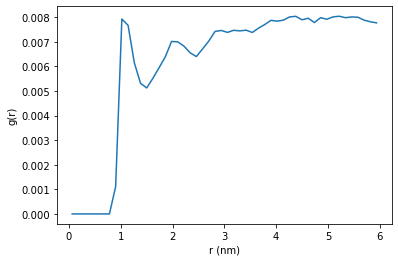

In [133]:
A_name = "ss"
B_name = "ss"

rdf = gsd_rdf(gsdfile, A_name, B_name, rmax=6)

plt.plot(rdf.bin_centers, rdf.rdf)
plt.xlabel("r (nm)")
plt.ylabel("g(r)")
plt.show()

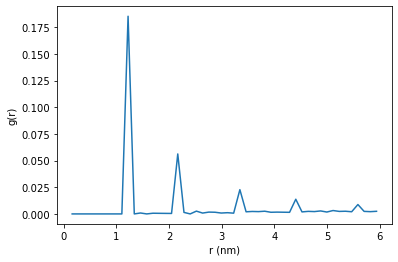

In [151]:
A_name = "ss"
B_name = "ss"

rdf = gsd_rdf(gsdfile, A_name, B_name, rmin=0.1, rmax=6, exclude_bonded=False)

plt.plot(rdf.bin_centers, rdf.rdf)
plt.xlabel("r (nm)")
plt.ylabel("g(r)")
plt.show()